In [152]:
# import libraries
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import numpy as np
import sklearn
import psycopg2 as psy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
%matplotlib inline
plt.style.use("ggplot")
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from collections import Counter
from __future__ import division
from matplotlib.ticker import AutoMinorLocator, FixedLocator
from sklearn.preprocessing import LabelEncoder

### Read in data and create db on local server

In [153]:
# read in csvs
cancel = pd.read_csv("assets/airport_cancellations.csv")
operations = pd.read_csv("assets/airport_operations.csv")
airports = pd.read_csv("assets/airports.csv")

In [154]:
# set all column names to lower case (easier in sql)
cancel.columns = [i.lower() for i in cancel.columns.values]
#initial exploration
cancel.head(1)

,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0


In [155]:
operations.head(1)

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87


In [156]:
airports.columns = [i.lower() for i in airports.columns.values]
airports.head(2)

,key,locid,ap_name,alias,facility type,faa region,county,city,state,ap type,latitude,longitude,boundary data available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No


In [157]:
# replace missing airport names with nan
airports.replace('#NAME?', np.nan, inplace=True)

In [158]:
#check to see how much missingness
print np.sum(airports.isnull())
print "\n"
print np.sum(cancel.isnull())
print "\n"
print np.sum(operations.isnull())

key                           3
locid                        15
ap_name                       3
alias                      1669
facility type                 3
faa region                    3
county                       15
city                          3
state                         3
ap type                       3
latitude                      3
longitude                     3
boundary data available       3
dtype: int64


airport                    0
year                       0
departure cancellations    0
arrival cancellations      0
departure diversions       0
arrival diversions         0
dtype: int64


airport                               0
year                                  0
departures for metric computation     0
arrivals for metric computation       0
percent on-time gate departures       0
percent on-time airport departures    0
percent on-time gate arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average taxi out del

In [159]:
# drop airports that don't have LocID (id needed to join tables)
airports= airports[~pd.isnull(airports["locid"])]

In [160]:
# check number unique values of airport ids
print len(set(cancel["airport"]))
print len(set(operations["airport"]))
print len(set(airports["locid"]))

74
77
5152


In [161]:
# check number of entries
print len(cancel)
print len(operations)
print len(airports)

805
841
5152


In [162]:
# check airport / year numbers for cancellations and operations to see where data is missing
cancel_counts = pd.pivot_table(cancel, index=["airport"], columns = ["year"],\
                               values = ["arrival cancellations"],aggfunc=(len))
cancel_counts["num_years"] = cancel_counts.apply(sum, axis=1)

In [163]:
# print airports that have missing data in cancellations
cancel_counts[pd.isnull(cancel_counts["num_years"])]

arrival cancellations                                            \
year                   2004.0 2005.0 2006.0 2007.0 2008.0 2009.0 2010.0   
airport                                                                   
OXR                       1.0    1.0    1.0    1.0    1.0    1.0    1.0   
RFD                       NaN    NaN    1.0    1.0    1.0    NaN    NaN   

                                    num_years  
year    2011.0 2012.0 2013.0 2014.0            
airport                                        
OXR        NaN    NaN    NaN    NaN       NaN  
RFD        1.0    1.0    1.0    NaN       NaN

In [164]:
operation_counts = pd.pivot_table(operations, index=["airport"], columns = ["year"],\
                                  values = ["average_gate_departure_delay"],aggfunc=(len))
operation_counts["num_years"] = operation_counts.apply(sum, axis=1)

In [165]:
# print airports that have missing data in operations
operation_counts[pd.isnull(operation_counts["num_years"])]

average_gate_departure_delay                                          \
year                            2004 2005 2006 2007 2008 2009 2010 2011 2012   
airport                                                                        
PSP                              NaN  NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0   
SMF                              NaN  NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0   

                  num_years  
year    2013 2014            
airport                      
PSP      1.0  1.0       NaN  
SMF      1.0  1.0       NaN

In [166]:
# they are not the same airports, so some data will be dropped from both dataframes
# count number of airports in both cancellations and operations
len([i for i in list(set(cancel["airport"])) if i in list(set(operations["airport"]))])

74

** Good news is that all airports in cancellations are also operations **

In [167]:
# make the tables in local postgres db
engine = create_engine('postgresql://localhost:5432/airports')

In [168]:
cancel.to_sql('cancel', engine, if_exists='replace')
operations.to_sql('operations', engine, if_exists='replace')
airports.to_sql('airports', engine, if_exists='replace')

In [169]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


**Test the database by querying**

In [170]:
%%sql postgresql://localhost:5432/airports
        
SELECT * from cancel limit 5

5 rows affected.


index,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


**Update the tables such that index is primary key in each**

In [171]:
%%sql
ALTER TABLE cancel ADD PRIMARY KEY (index);

Done.


[]

In [172]:
%%sql
ALTER TABLE operations ADD PRIMARY KEY (index);

Done.


[]

In [173]:
%%sql
ALTER TABLE airports ADD PRIMARY KEY (index);

Done.


[]

In [174]:
# create master join of operations, cancellations and airports, save to df to do analysis
air = %sql SELECT * FROM cancel c JOIN operations o ON (c.airport = o.airport AND c.year = o.year)\
JOIN airports a ON (c.airport = a.locid)
air = air.DataFrame()

799 rows affected.


In [175]:
print len(air), "rows of data"
# rows where we have all the information

799 rows of data


### EDA

In [176]:
air.head(1)

,index,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,index,airport,year,...,alias,facility type,faa region,county,city,state,ap type,latitude,longitude,boundary data available
0,727,SJU,2014.0,280.0,241.0,72.0,31.0,744,SJU,2014,...,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,None,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes


In [177]:
# drop all the index columns
air.drop("index", axis=1, inplace=True)

In [178]:
# there are some repeated columns names - rename them
cnt = Counter(air.columns.values)
cols = []
for i, col in enumerate(air.columns.values):
    if cnt[col]>1:
        cols.append(col+str(i))
    else:
        cols.append(col)

In [179]:
air.columns = cols

In [180]:
# check that airport and locid really do match up
np.sum(air["airport0"]!=air["locid"])

0

In [181]:
# drop duplicated columns, and unnecessary ones
drops = ['airport6', u'year7','key','locid','boundary data available']
air.drop(drops,axis=1,inplace=True)

In [182]:
#check variable types
air.dtypes

airport0                               object
year1                                 float64
departure cancellations               float64
arrival cancellations                 float64
departure diversions                  float64
arrival diversions                    float64
departures for metric computation       int64
arrivals for metric computation         int64
percent on-time gate departures       float64
percent on-time airport departures    float64
percent on-time gate arrivals         float64
average_gate_departure_delay          float64
average_taxi_out_time                 float64
average taxi out delay                float64
average airport departure delay       float64
average airborne delay                float64
average taxi in delay                 float64
average block delay                   float64
average gate arrival delay            float64
ap_name                                object
alias                                  object
facility type                     

In [183]:
#rename columns to remove numbering
air.columns = ['airport', u'year'] + list(air.columns.values)[2:]

In [184]:
# convert year to int
air["year"] = air["year"].astype(int)

In [185]:
air.head(1)

,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,...,ap_name,alias,facility type,faa region,county,city,state,ap type,latitude,longitude
0,SJU,2014,280.0,241.0,72.0,31.0,43671,42965,0.8056,0.7784,...,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,None,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004


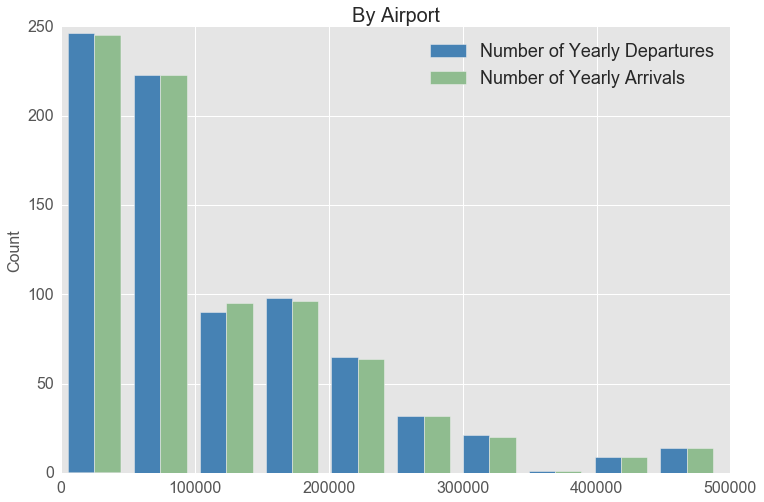

In [186]:
# plot distribution of departures and arrivals
fig, ax = plt.subplots(figsize=(12,8))
ax.hist([air["departures for metric computation"],air["arrivals for metric computation"]], \
        color=["steelblue","darkseagreen"],bins=10, histtype='bar')

plt.title('By Airport', fontsize=20)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(labels=["Number of Yearly Departures","Number of Yearly Arrivals"], prop={'size':18}, loc='best')

** Somewhat normal, but very fat left tail**

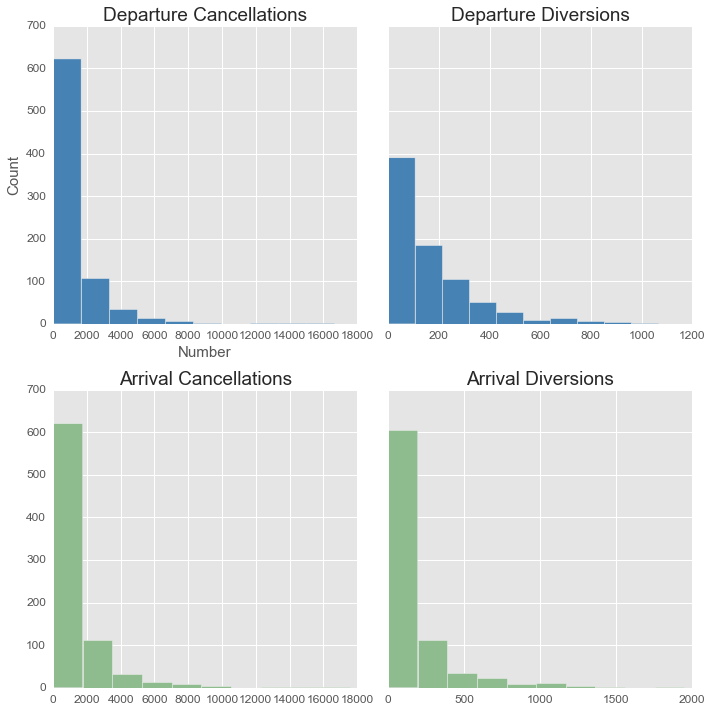

In [187]:
# plot distributions of cancellations / diversions
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10),sharey=True)
for ax, var, c in zip([ax1,ax2,ax3,ax4],["departure cancellations","departure diversions","arrival cancellations",\
                                     "arrival diversions"],["steelblue","steelblue","darkseagreen","darkseagreen"]):

    air[var].hist(ax=ax, color=c)
    ax.set_title(var.title(), fontsize=19)
    ax.tick_params(labelsize=12)

ax1.set_xlabel("Number", fontsize=15)
ax1.set_ylabel("Count", fontsize=15)
plt.tight_layout()


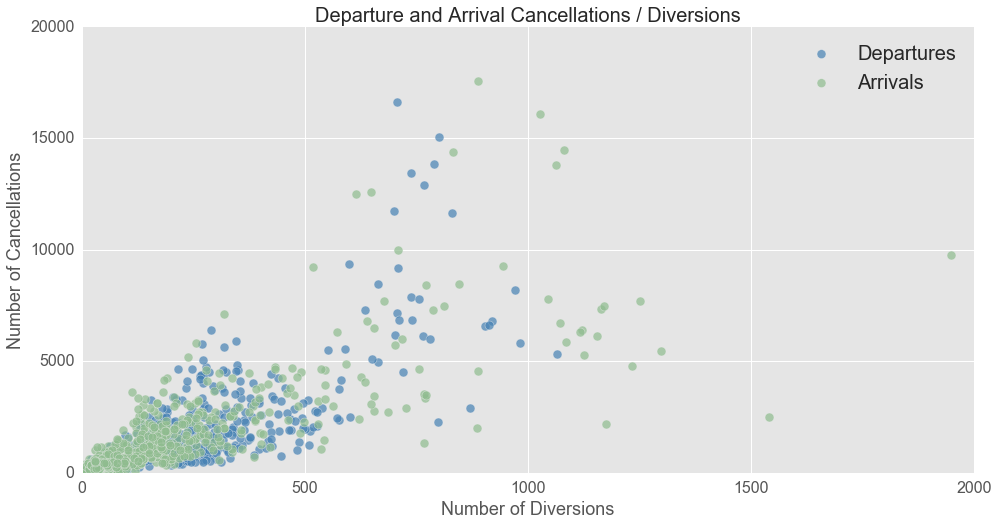

In [188]:
# diversion and cancellations 
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x=air['departure diversions'],y=air['departure cancellations'],s=80,c="steelblue", alpha=0.7, label="Departures")
ax.scatter(x=air['arrival diversions'],y=air['arrival cancellations'],s=80,c="darkseagreen", alpha=0.7, label="Arrivals")
ax.set_title("Departure and Arrival Cancellations / Diversions",fontsize=20)
ax.set(xlim=[0,2000],ylim=[0,20000])
ax.set_ylabel("Number of Cancellations", fontsize=18)
ax.set_xlabel("Number of Diversions",fontsize=18)
ax.tick_params(labelsize=16)

plt.legend(prop={'size':20})


** Number of diversions and cancellations positively correlated, for both departures and arrivals.  Not a big difference between departures and arrivals.  **

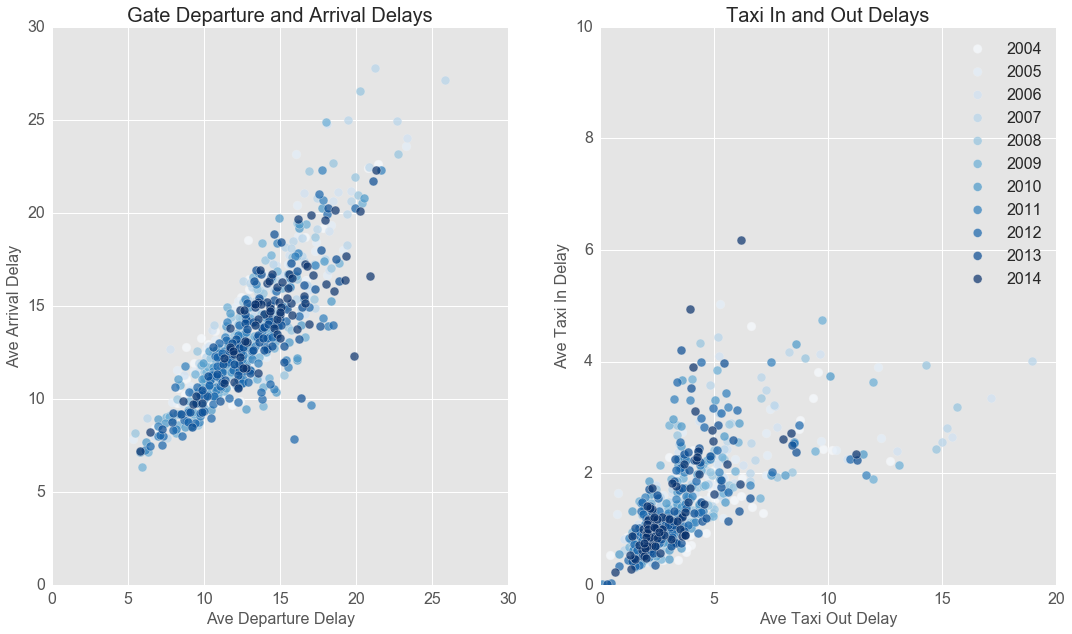

In [189]:
# arrival vs departure delays by year

fig, ax = plt.subplots(1,2,figsize=(18,10))
years=labels = list(set(air["year"]))
color=cm.Blues(np.linspace(0,1,len(years)))
for y,c in zip(years,color):
    sub=air[air["year"]==y]
    ax[0].scatter(x=sub['average_gate_departure_delay'],y=sub['average gate arrival delay'],s=80,c=c, alpha=0.7, label=y,cmap='Blues')
ax[0].set(xlim=[0,30],ylim=[0,30])
ax[0].set_title("Gate Departure and Arrival Delays", fontsize=20)
ax[0].set_ylabel("Ave Arrival Delay", fontsize=16)
ax[0].set_xlabel("Ave Departure Delay",fontsize=16)
ax[0].tick_params(labelsize=16)

for y,c in zip(years,color):
    sub=air[air["year"]==y]
    ax[1].scatter(x=sub['average taxi out delay'],y=sub['average taxi in delay'],c=c, s=80,alpha=0.7,label=y,cmap='Blues')
ax[1].set(xlim=[0,20],ylim=[0,10])
ax[1].set_title("Taxi In and Out Delays", fontsize=20)
ax[1].set_ylabel("Ave Taxi In Delay", fontsize=16)
ax[1].set_xlabel("Ave Taxi Out Delay",fontsize=16)
ax[1].tick_params(labelsize=16)

plt.legend(prop={'size':16})


** No obvious trend over time**

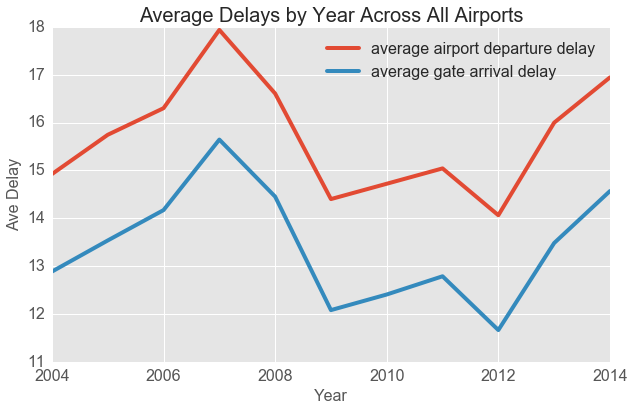

In [190]:
# trend of average delays
fig, ax = plt.subplots(figsize=(10,6))
temp = pd.pivot_table(air,index=["year"],values=["average airport departure delay","average gate arrival delay"],\
               aggfunc=np.mean)
temp.plot(ax=ax, linewidth=4)
ax.set_title("Average Delays by Year Across All Airports", fontsize=20)
ax.set_ylabel("Ave Delay", fontsize=16)
ax.set_xlabel("Year",fontsize=16)
ax.tick_params(labelsize=16)

plt.legend(prop={'size':16})

** Confirms no clear trend.**

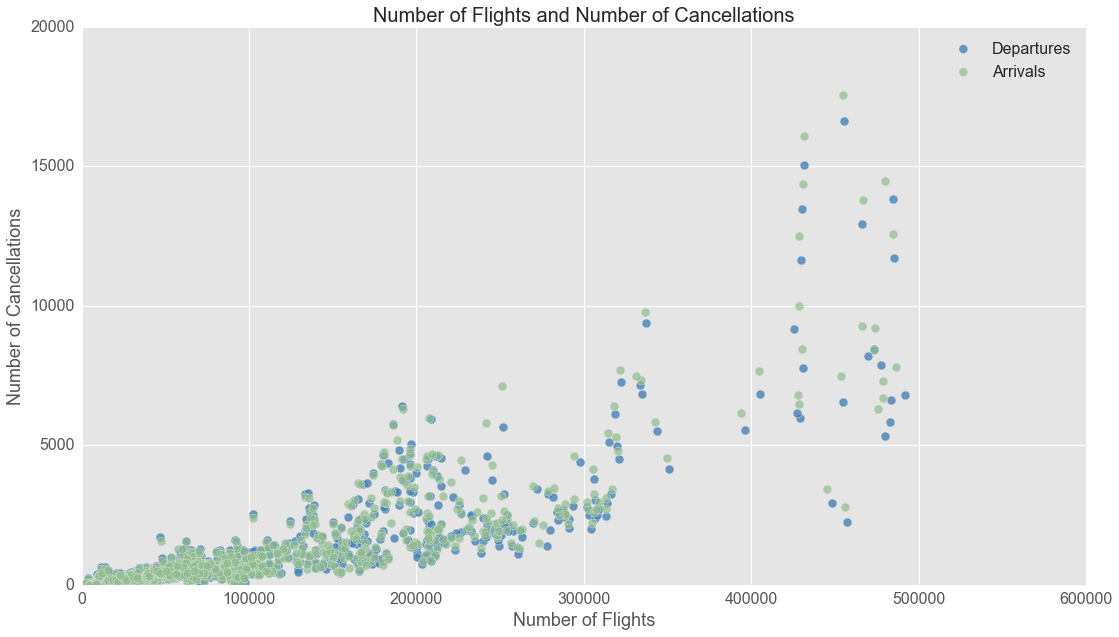

In [191]:
#number of cancellations vs number of flights
fig, ax = plt.subplots(figsize=(18,10))
ax.scatter(y=air['departure cancellations'],x=air['departures for metric computation'],s=80,c="steelblue", alpha=0.8, label="Departures")
ax.scatter(y=air['arrival cancellations'],x=air['arrivals for metric computation'],s=80,c="darkseagreen", alpha=0.7, label="Arrivals")
ax.set_xlabel("Number of Flights", fontsize=18)
ax.set_ylabel("Number of Cancellations",fontsize=18)
ax.tick_params(labelsize=16)
ax.set(xlim=[0,600000],ylim=[0,20000])
ax.set_title("Number of Flights and Number of Cancellations", fontsize=20)
plt.legend(prop={'size':16})

** More flights -> more cancellations, but rate increases with number of flights (looks quadratic)**

In [192]:
# create list of numeric cols
numeric_cols = ['departure cancellations',
       u'arrival cancellations', u'departure diversions',
       u'arrival diversions', u'departures for metric computation',
       u'arrivals for metric computation',
       u'percent on-time gate departures',
       u'percent on-time airport departures',
       u'percent on-time gate arrivals', u'average_gate_departure_delay',
       u'average_taxi_out_time', u'average taxi out delay',
       u'average airport departure delay', u'average airborne delay',
       u'average taxi in delay', u'average block delay',
       u'average gate arrival delay']

In [193]:
# show summary stats
air.loc[:,numeric_cols].describe()

,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,1299.314143,1341.068836,174.250313,170.256571,113471.568210,113003.959950,0.779123,0.726958,0.766864,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811
std,1840.877193,1980.459892,172.638408,229.162686,98059.144667,97705.308115,0.052279,0.076027,0.050502,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647
min,0.000000,0.000000,0.000000,0.000000,731.000000,717.000000,0.529900,0.380800,0.513600,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000
25%,349.000000,314.500000,62.000000,41.000000,42064.000000,42006.500000,0.753100,0.691800,0.742150,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000
50%,670.000000,653.000000,111.000000,84.000000,79489.000000,79750.000000,0.784100,0.740200,0.770500,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000
75%,1483.500000,1542.000000,237.000000,190.000000,166469.500000,165560.500000,0.810700,0.773700,0.797600,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000
max,16618.000000,17571.000000,1064.000000,1948.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000


In [194]:
air.sort_values("departure cancellations").tail()

,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,...,ap_name,alias,facility type,faa region,county,city,state,ap type,latitude,longitude
691,ORD,2006,12915.0,13808.0,766.0,1063.0,466079,467039,0.7036,0.5881,...,CHICAGO O'HARE INTL,Chicago Ohare Int'l Airport,Airport,AGL,COOK,CHICAGO,IL,Federalized/Commercial,41.981649,-87.906671
683,ORD,2014,13454.0,14355.0,739.0,831.0,430429,430750,0.6787,0.5784,...,CHICAGO O'HARE INTL,Chicago Ohare Int'l Airport,Airport,AGL,COOK,CHICAGO,IL,Federalized/Commercial,41.981649,-87.906671
240,ATL,2005,13837.0,14480.0,790.0,1080.0,484570,480171,0.7413,0.6216,...,HARTSFIELD - JACKSON ATLANTA INTL,Hartsfield-Jackson Atlanta Int'l,Airport,ASO,FULTON,ATLANTA,GA,Federalized/Commercial,33.636700,-84.427864
689,ORD,2008,15050.0,16094.0,801.0,1027.0,431539,431421,0.7049,0.6115,...,CHICAGO O'HARE INTL,Chicago Ohare Int'l Airport,Airport,AGL,COOK,CHICAGO,IL,Federalized/Commercial,41.981649,-87.906671
690,ORD,2007,16618.0,17571.0,707.0,887.0,455562,455118,0.6854,0.5769,...,CHICAGO O'HARE INTL,Chicago Ohare Int'l Airport,Airport,AGL,COOK,CHICAGO,IL,Federalized/Commercial,41.981649,-87.906671


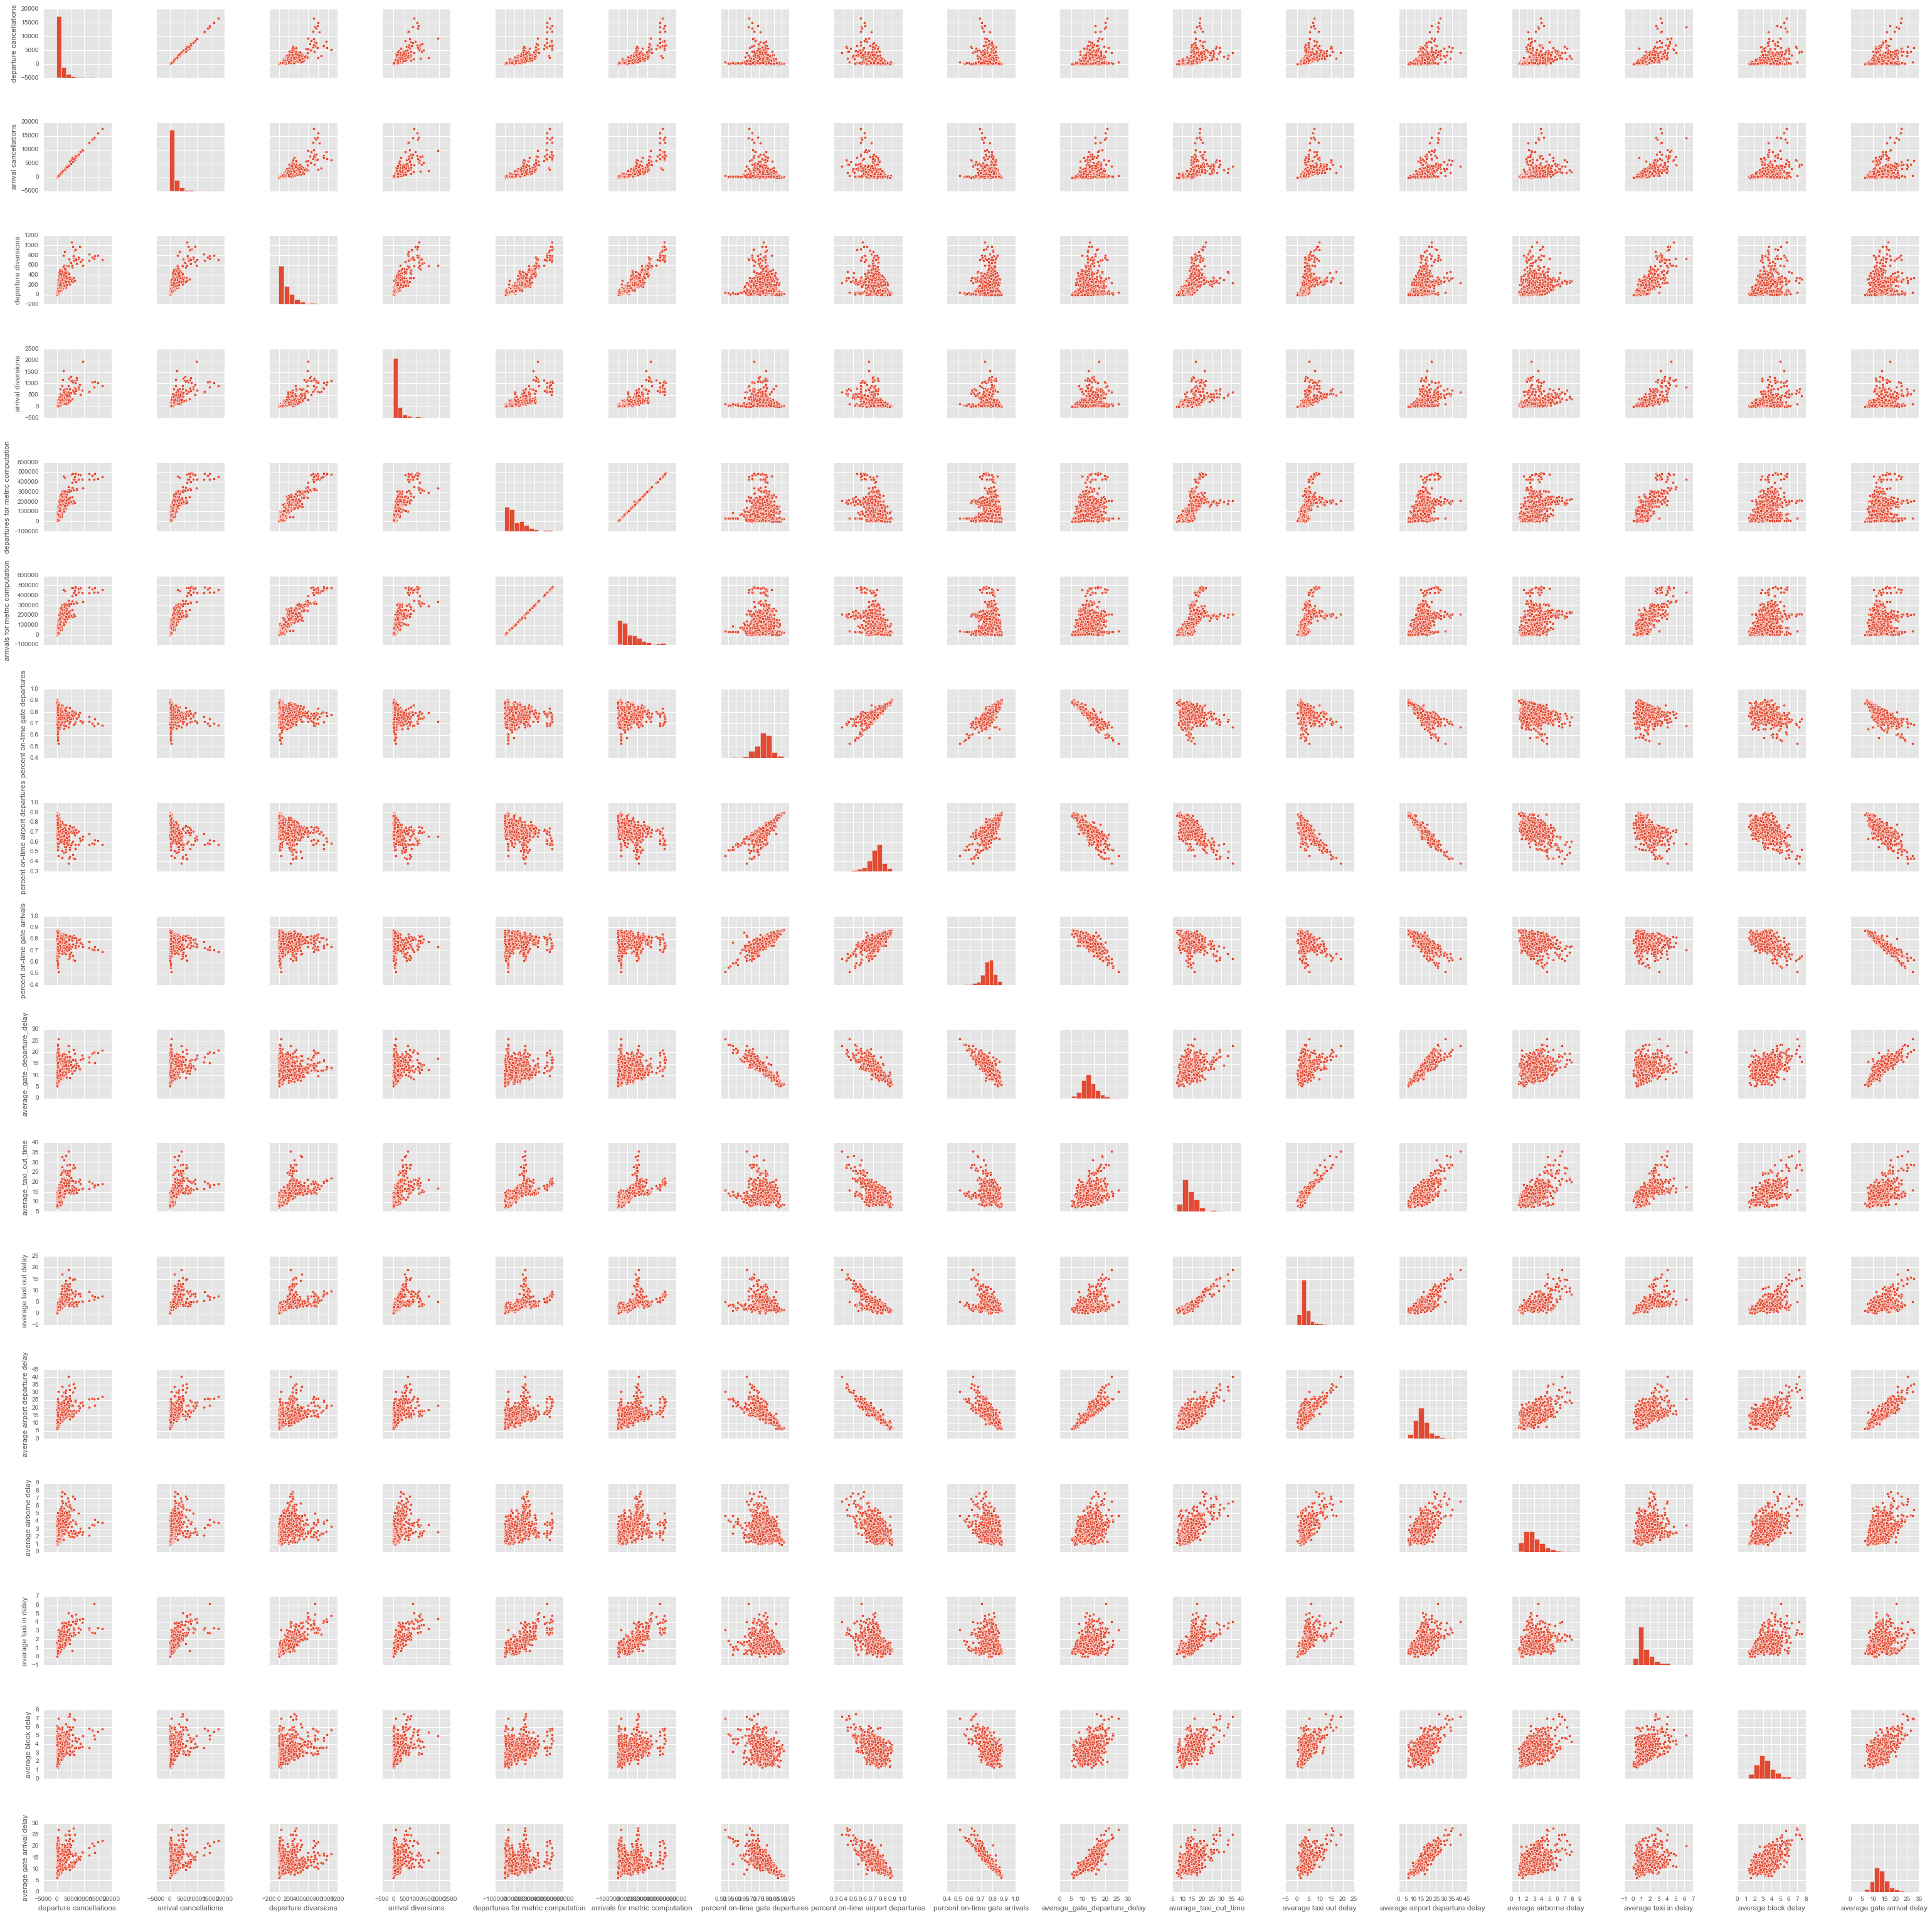

In [195]:
# plot cross pairs
sns.pairplot(air.loc[:,numeric_cols])

In [196]:
# cross correlations
air.loc[:,numeric_cols].corr()

,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
departure cancellations,1.000000,0.997464,0.796385,0.792253,0.808959,0.809994,-0.183962,-0.466213,-0.113363,0.291753,0.566103,0.599671,0.504939,0.376828,0.723515,0.396928,0.325605
arrival cancellations,0.997464,1.000000,0.814378,0.793773,0.823676,0.824622,-0.172420,-0.453081,-0.094130,0.275300,0.559625,0.588159,0.487547,0.367273,0.730266,0.388365,0.305527
departure diversions,0.796385,0.814378,1.000000,0.840401,0.934147,0.934035,-0.051995,-0.357375,0.067575,0.124451,0.571622,0.554316,0.360954,0.280685,0.816581,0.330366,0.127359
arrival diversions,0.792253,0.793773,0.840401,1.000000,0.798750,0.799456,-0.142091,-0.431068,-0.028064,0.218199,0.558053,0.581730,0.444050,0.322749,0.785480,0.379282,0.219782
departures for metric computation,0.808959,0.823676,0.934147,0.798750,1.000000,0.999807,-0.063251,-0.399942,0.103680,0.131396,0.638656,0.604125,0.391838,0.401505,0.823040,0.358669,0.102899
arrivals for metric computation,0.809994,0.824622,0.934035,0.799456,0.999807,1.000000,-0.062713,-0.399040,0.104228,0.129871,0.636674,0.603439,0.390470,0.400179,0.822057,0.355442,0.101622
percent on-time gate departures,-0.183962,-0.172420,-0.051995,-0.142091,-0.063251,-0.062713,1.000000,0.818598,0.782703,-0.913107,-0.169598,-0.212539,-0.764464,-0.265446,-0.162607,-0.342640,-0.712282
percent on-time airport departures,-0.466213,-0.453081,-0.357375,-0.431068,-0.399942,-0.399040,0.818598,1.000000,0.695697,-0.826633,-0.653223,-0.725766,-0.954832,-0.558150,-0.495327,-0.561451,-0.753545
percent on-time gate arrivals,-0.113363,-0.094130,0.067575,-0.028064,0.103680,0.104228,0.782703,0.695697,1.000000,-0.800603,-0.230311,-0.287357,-0.712975,-0.271240,-0.087212,-0.550010,-0.922723
average_gate_departure_delay,0.291753,0.275300,0.124451,0.218199,0.131396,0.129871,-0.913107,-0.826633,-0.800603,1.000000,0.331777,0.339046,0.886479,0.328084,0.249073,0.435036,0.850259


** Seems to be a lot of correlation in delay data.   PCA will be used to condense info to fewer dimensions. **

In [197]:
# create list of delay metric columns - taxi out time is excluded because it's not necessarily a delay metric
# , u'average_taxi_out_time'
delay_cols = [ u'departure cancellations',
       u'arrival cancellations', u'departure diversions',
       u'arrival diversions', 
       u'percent on-time gate departures',
    u'percent on-time airport departures',
       u'percent on-time gate arrivals', u'average_gate_departure_delay',
        u'average taxi out delay',
       u'average airport departure delay', u'average airborne delay',
       u'average taxi in delay', u'average block delay',
       u'average gate arrival delay']

### PCA and Clustering

In [198]:
# scale the data for PCA
x_scale = StandardScaler().fit_transform(air.loc[:,delay_cols])

In [199]:
# test the number of pcs to use 
for i in range(1,6):
    pca = PCA(n_components=i)
    pca.fit(x_scale)
    print i, sum(pca.explained_variance_ratio_)

1 0.537637782536
2 0.777554631446
3 0.85046160901
4 0.895738164258
5 0.928818419271


In [200]:
# let's use 3 components since that gets us 85% of variance
pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(x_scale), columns = ["pc1","pc2","pc3"])

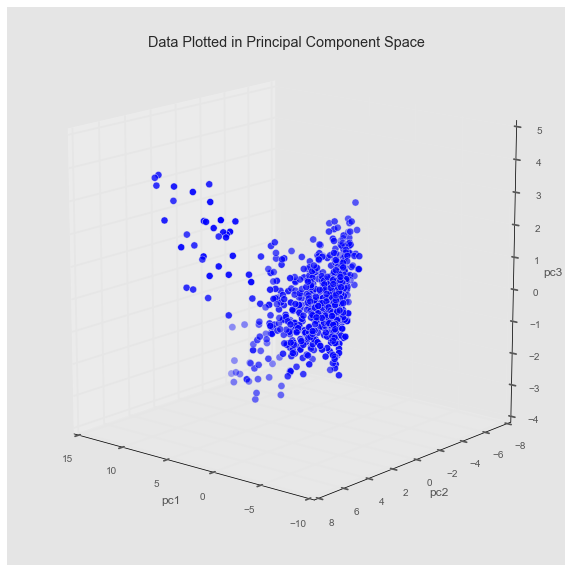

In [201]:
# plot data in pc space
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df["pc1"],pca_df["pc2"],pca_df["pc3"], s=50)
ax.set(xlabel="pc1",ylabel="pc2",zlabel="pc3")
ax.set_title("Data Plotted in Principal Component Space")
ax.view_init(15, 130)
plt.draw()

In [245]:
# create gif images
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df["pc1"],pca_df["pc2"],pca_df["pc3"], s=50)
ax.set(xlabel="pc1",ylabel="pc2",zlabel="pc3")
ax.set_title("Data Plotted in Principal Component Space")
for i in range(0,360,15):
    ax.view_init(15, i)
    filename="rotate"+str(i)+".jpg"
    plt.savefig(filename)
        
plt.close(fig)


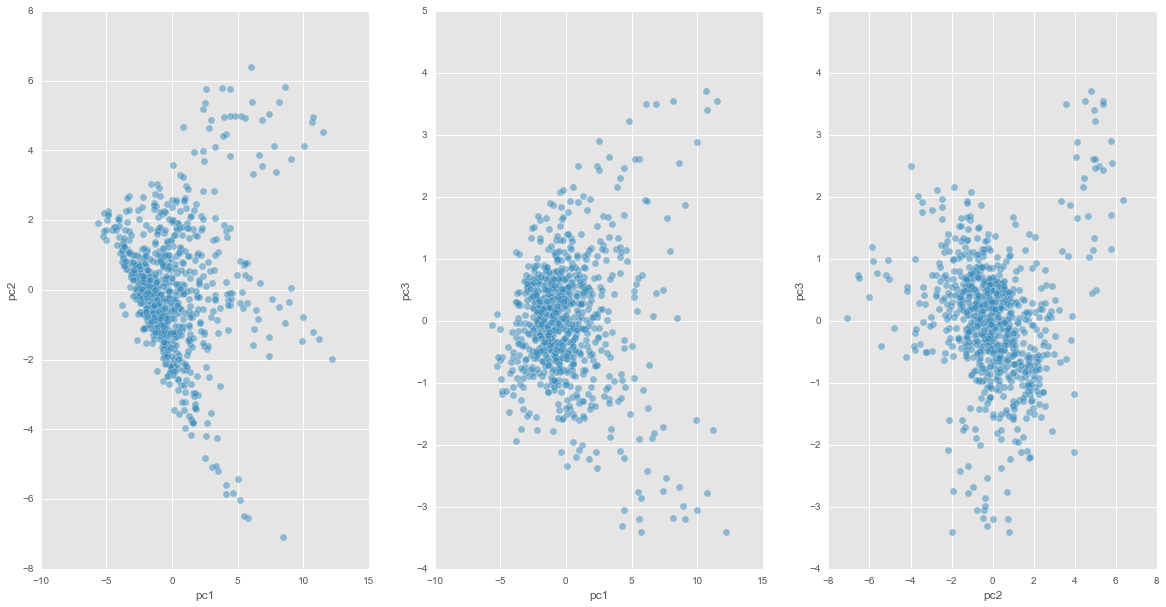

In [202]:
# project into 2d to help examine clustering
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))

pca_df.plot(x="pc1",y="pc2",kind="scatter",alpha=0.5,s=50,ax=ax1)
pca_df.plot(x="pc1",y="pc3",kind="scatter",alpha=0.5,s=50,ax=ax2)
pca_df.plot(x="pc2",y="pc3",kind="scatter",alpha=0.5,s=50,ax=ax3)

In [203]:
# use kmeans clustering.  test 2 to 9 clusters, to determine highest silhouette score
for n in range (2,10):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(x_scale)
    print n, silhouette_score(x_scale,kmeans.labels_)
    
# 2 clusters provide highest silhouette score
kmeans = KMeans(n_clusters=2)
kmeans.fit(x_scale)
silhouette_score(x_scale,kmeans.labels_)

2 0.454566877973
3 0.26398633586
4 0.249725601118
5 0.260643644977
6 0.231661594396
7 0.239997076723
8 0.219479839956
9 0.220612979625


0.45456687797264922

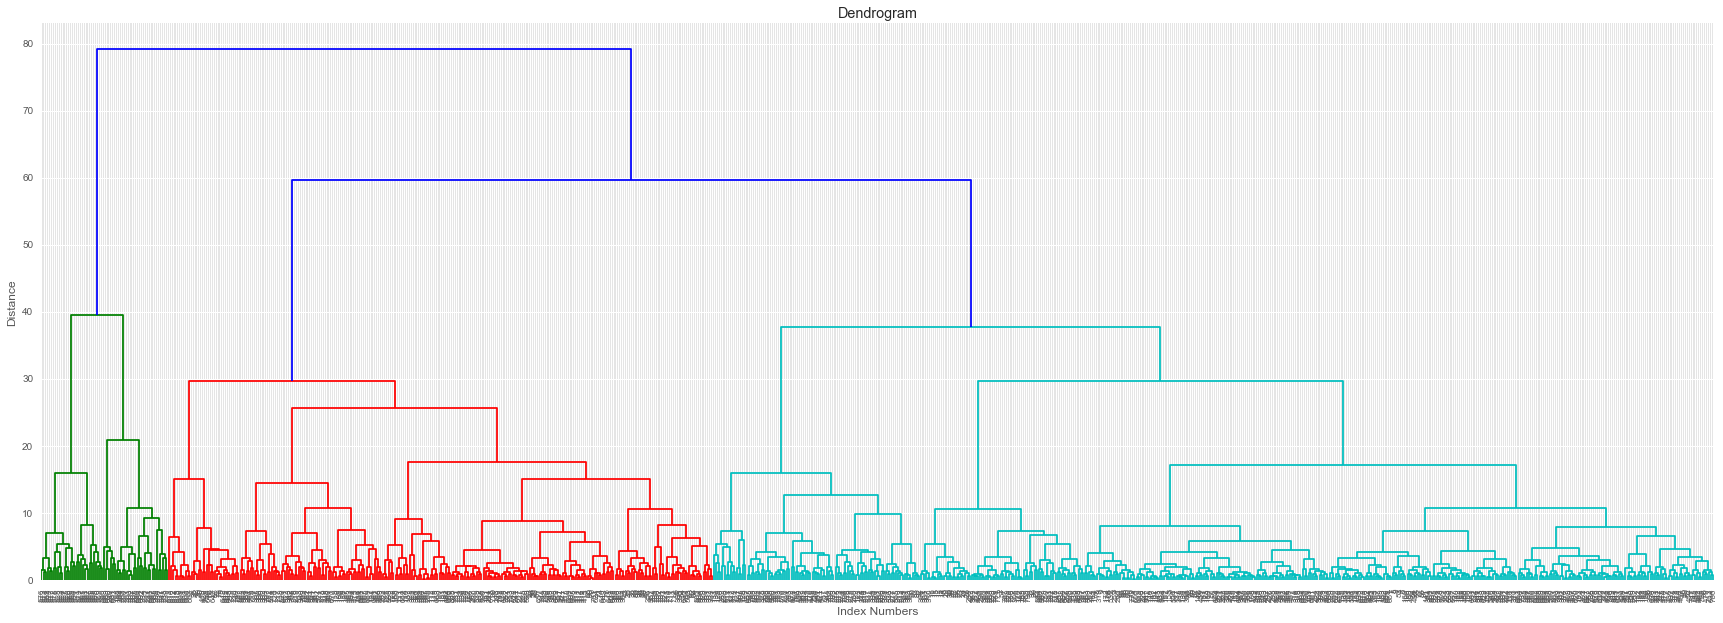

In [204]:
# try hierarchical
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
Z = linkage(x_scale, 'ward')
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

In [205]:
# test silhouette score for different cuts
for max_d in range(10,70,10):
    clusters = fcluster(Z, max_d, criterion='distance')
    print max_d, silhouette_score(x_scale,clusters)

10 0.145446626337
20 0.203728961833
30 0.243071067868
40 0.259277992483
50 0.259277992483
60 0.546606806146


In [240]:
# again 2 clusters gives highest silhouette
clusters = fcluster(Z, 60, criterion='distance')
#check number of members of each cluster for hierarchical vs kmeans
print Counter(clusters)
print Counter(kmeans.labels_)

Counter({2: 738, 1: 61})
Counter({0: 650, 1: 149})


In [241]:
# similar numbers, hierarchical gives slightly higher silhouette score, so will use those cluster labels
labels = clusters

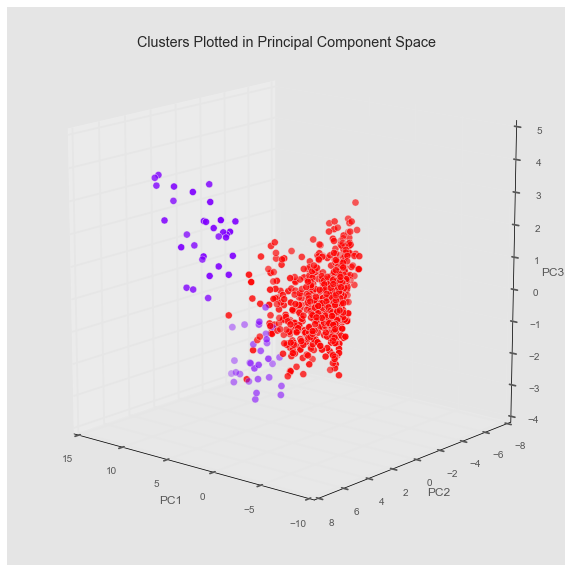

In [243]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Clusters Plotted in Principal Component Space")
ax.scatter(pca_df["pc1"],pca_df["pc2"],pca_df["pc3"], c=labels, cmap='rainbow',s=50)
ax.set(xlabel="PC1", ylabel = "PC2", zlabel="PC3")
ax.view_init(15, 130)
plt.draw()

In [244]:
# create gif images
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
ax.set_title("Clusters Plotted in Principal Component Space")
ax.scatter(pca_df["pc1"],pca_df["pc2"],pca_df["pc3"], c=labels, cmap="rainbow", s=50)
ax.set(xlabel="PC1", ylabel = "PC2", zlabel="PC3")
for i in range(0,360,15):
    ax.view_init(15, i)
    filename="rotate_cluster"+str(i)+".jpg"
    plt.savefig(filename)
        
plt.close(fig)


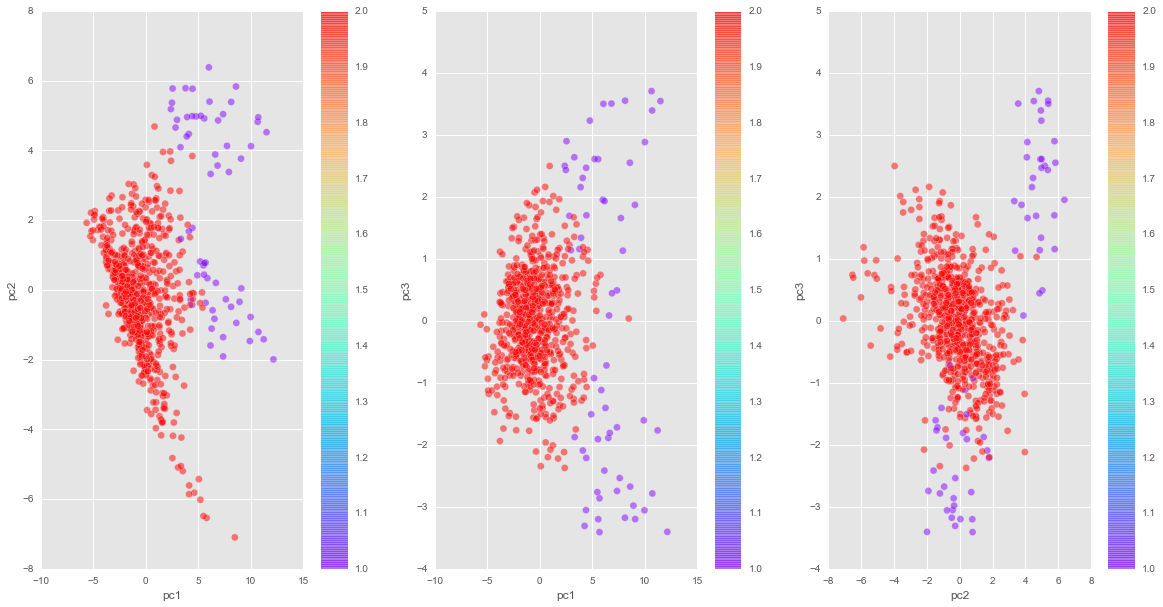

In [209]:
# project into 2d to examine
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))

pca_df.plot(x="pc1",y="pc2",kind="scatter",c=labels, cmap='rainbow',alpha=0.5,s=50,ax=ax1)
pca_df.plot(x="pc1",y="pc3",kind="scatter",c=labels, cmap='rainbow',alpha=0.5,s=50,ax=ax2)
pca_df.plot(x="pc2",y="pc3",kind="scatter",c=labels, cmap='rainbow',alpha=0.5,s=50,ax=ax3)

In [210]:
# add labels to original dataframe
air["cluster_delays"] = labels

In [211]:
# most of the separation is along pc1, check eignvectors to see if anything dominates pc1
components_df = pd.DataFrame(pca.components_.T, columns=["pc1","pc2","pc3"])
components_df["features"] = delay_cols
components_df
#nothing stands out

,pc1,pc2,pc3,features
0,0.267201,0.299922,0.189196,departure cancellations
1,0.263348,0.310137,0.197344,arrival cancellations
2,0.223137,0.375310,0.167947,departure diversions
3,0.245194,0.325765,0.163857,arrival diversions
4,-0.237245,0.328590,-0.317592,percent on-time gate departures
5,-0.329077,0.154379,0.012540,percent on-time airport departures
6,-0.228105,0.375208,-0.058725,percent on-time gate arrivals
7,0.274054,-0.301453,0.260447,average_gate_departure_delay
8,0.286865,0.126688,-0.399771,average taxi out delay
9,0.337886,-0.154477,-0.005966,average airport departure delay


### Analysis of Clusters - Comparison

In [212]:
# see number of airport/years in each cluster
air["cluster_delays"].value_counts()

2    738
1     61
Name: cluster_delays, dtype: int64

In [213]:
# compare the delay metric averages for the two clusters
# cluster 1
air[air["cluster_delays"]==1].describe().loc["mean",numeric_cols].to_frame()

,mean
departure cancellations,6012.590164
arrival cancellations,6339.950820
departure diversions,522.081967
arrival diversions,733.639344
departures for metric computation,309086.754098
arrivals for metric computation,308108.737705
percent on-time gate departures,0.746259
percent on-time airport departures,0.591466
percent on-time gate arrivals,0.733236
average_gate_departure_delay,15.941311


In [214]:
#cluster 2
air[air["cluster_delays"]==2].describe().loc["mean",numeric_cols].to_frame()

,mean
departure cancellations,909.734417
arrival cancellations,927.882114
departure diversions,145.500000
arrival diversions,123.689702
departures for metric computation,97302.833333
arrivals for metric computation,96877.413279
percent on-time gate departures,0.781839
percent on-time airport departures,0.738157
percent on-time gate arrivals,0.769643
average_gate_departure_delay,12.638062


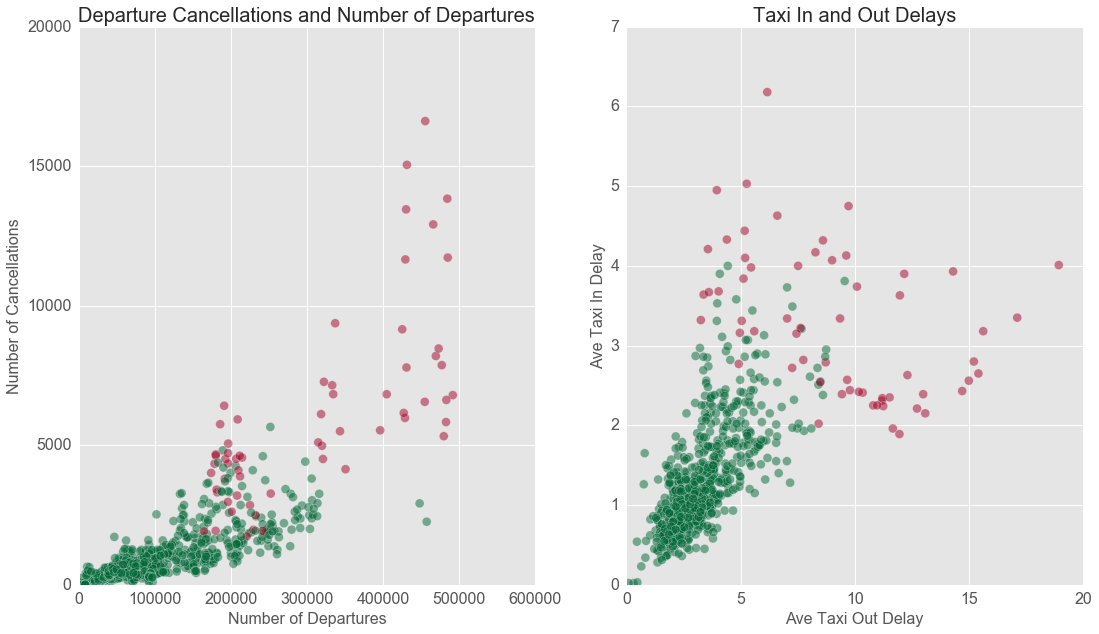

In [215]:
# cluster 2 is better
# show clusters in 2D on original data
labs = air["cluster_delays"]
fig, ax = plt.subplots(1,2,figsize=(18,10))

ax[0].scatter(x=air['departures for metric computation'],y=air['departure cancellations'], s=80,c=labs,alpha=0.5,cmap='RdYlGn')
ax[0].set(xlim=[0,600000],ylim=[0,20000])
ax[0].set_title("Departure Cancellations and Number of Departures", fontsize=20)
ax[0].set_ylabel("Number of Cancellations", fontsize=16)
ax[0].set_xlabel("Number of Departures",fontsize=16)
ax[0].tick_params(labelsize=16)

ax[1].scatter(x=air['average taxi out delay'],y=air['average taxi in delay'], s=80,c=labs,alpha=0.5,cmap='RdYlGn')
ax[1].set(xlim=[0,20],ylim=[0,7])
ax[1].set_title("Taxi In and Out Delays", fontsize=20)
ax[1].set_ylabel("Ave Taxi In Delay", fontsize=16)
ax[1].set_xlabel("Ave Taxi Out Delay",fontsize=16)
ax[1].tick_params(labelsize=16)

# plt.legend(prop={'size':16})


In [216]:
# create list of airports that only appear in cluster 2 (consistently better airports)
better = list(set(air[air["cluster_delays"]==2]["airport"]))

In [217]:
# create list of airports that only appear in cluster 1 (consistently worse airports)
worse = list(set(air[air["cluster_delays"]==1]["airport"]))
worse_only = [i for i in worse if i not in better]
print len(worse_only), "airports only in worse cluster"

3 airports only in worse cluster


In [218]:
better_only = [i for i in better if i not in worse]
print len(better_only), "airports only in good cluster"

67 airports only in good cluster


In [219]:
#print names of problem airports
list(set(air[air["airport"].isin(worse_only)]["alias"]))

[u"Dallas/Ft Worth Int'l Airport",
 u"Chicago Ohare Int'l Airport",
 u'Laguardia Airport']

In [220]:
# total number of airports
len(list(set(air["airport"])))

74

In [221]:
# find airports that move between the two clusters year over year
# create a df of clusters by airport and year
yoy_clusters = pd.pivot_table(air,index=["airport"], columns = ["year"], values=["cluster_delays"])
yoy_clusters.columns = yoy_clusters.columns.droplevel()
yoy_clusters.head()

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
airport,,,,,,,,,,,
ABQ,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
ANC,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
ATL,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0
AUS,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
BDL,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [222]:
# create list of airports that moved between years
improved = []
worsened = []
for ap in yoy_clusters.index:
    sub = list(yoy_clusters.loc[ap,:])
    for i,j in enumerate(sub):
        if i == len(sub)-1:
            pass
        elif sub[i]<sub[i+1]:
            improved.append(ap)
        elif sub[i]>sub[i+1]:
            worsened.append(ap)
        else:
            pass

In [223]:
print improved

[u'ATL', u'EWR', u'EWR', u'JFK', u'PHL']


In [224]:
print worsened

[u'ATL', u'EWR', u'JFK']


In [225]:
#make a list of unique movers
moved = list(set(improved + worsened))
#create df of movers data
movers = air[air["airport"].isin(moved)]
movers = movers.loc[:,["airport","year","cluster_delays"]]
movers.set_index("airport", inplace=True)
#encode the airport by number
movers["airport_num"] = LabelEncoder().fit_transform(movers.index)

In [226]:
#create list of airports for plot
lab=LabelEncoder().fit(movers.index)
air_labels = list(lab.classes_)

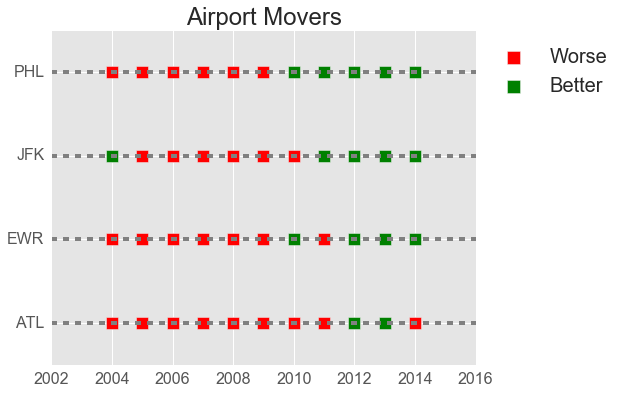

In [227]:
# plot cluster by year for movers
fig, ax = plt.subplots(figsize=(8,6))
for i, c,lab in zip(range(1,3),["red","green"],["Worse","Better"]):
    sub = movers[(movers["cluster_delays"]==i)]
    labels = sub["cluster_delays"]
    ax.scatter(x=sub["year"],y=sub["airport_num"], s=150, c=c, label=lab,marker="s")

for i in range(len(air_labels)):
    ax.axhline(y=i, c="gray", ls="dashed", linewidth=4)
major_locator = FixedLocator(range(len(air_labels)))
ax.yaxis.set_major_locator(major_locator)

labs = [item.get_text() for item in ax.get_yticklabels()]
for i, j in enumerate(air_labels):
    labs[i]=j
ax.set_yticklabels(labs, fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title("Airport Movers", fontsize=24)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
plt.legend(prop={'size':20}, loc=3, bbox_to_anchor=(1, 0.75))


In [228]:
#print names of movers
list(set(air[air["airport"].isin(moved)]["alias"]))

[u"Philadelphia Int'l Airport",
 u"Hartsfield-Jackson Atlanta Int'l",
 u"Newark Liberty Int'l Airport",
 u"John F Kennedy Int'l Airport"]

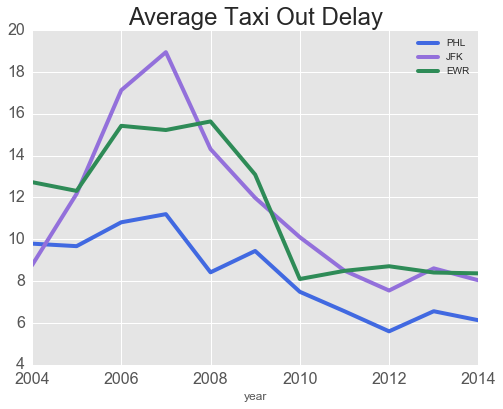

In [232]:
ap = ["PHL","JFK","EWR"]
colors=["royalblue","mediumpurple","seagreen"]
fig, ax = plt.subplots(figsize=(8,6))
for ap,c in zip(ap,colors):
    
    air[air["airport"]==ap].sort_values("year").plot(x="year",y='average taxi out delay',label=ap,color=c, \
                                                    linewidth=4,ax=ax)
ax.tick_params(labelsize=16)
ax.set_title("Average Taxi Out Delay", fontsize=24)

In [230]:
# write out location of consistent clusters for Tableau mapping
air[(~air["airport"].isin(moved))&(air["year"]==2014)]\
.loc[:,["airport","cluster_delays","latitude","longitude"]].to_csv("clusters.csv")

In [231]:
#write out average aiport size for Tableau mapping
temp=air.loc[:,["airport","year","departures for metric computation","arrivals for metric computation",\
                "longitude","latitude"]]
temp["ave"] = (temp["departures for metric computation"] + temp["arrivals for metric computation"]) / 2
pd.pivot_table(temp,index=["airport","longitude","latitude"],values=["ave"], aggfunc=np.mean).to_csv("airportsize.csv")

blog post is here: http://pclt.github.io/faa-delay-analysis/